In [2]:
from pprint import pprint
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
from tqdm import tqdm, tqdm_notebook
from collections import Counter
sns.set()
sns.set_context('talk')

In [3]:
df = pd.read_csv('./tennis_shuffled.csv', index_col=0)
df['seed_1'].fillna(999999, inplace=True)
df['seed_2'].fillna(999999, inplace=True)
df['rank_1'].fillna(999999, inplace=True)
df['rank_2'].fillna(999999, inplace=True)
df['rank_points_1'].fillna(0, inplace=True)
df['rank_points_2'].fillna(0, inplace=True)
df['surface'].fillna('Hard')
df['hand_1'].fillna('R')
df['hand_2'].fillna('R')
df.fillna(df.mean(), inplace=True)
df = pd.get_dummies(df)
print(df.shape)
df.head()

(50178, 77)


,W,draw_size,minutes,tiebreaks,best_of,seed_1,ht_1,age_1,rank_1,rank_points_1,...,hand_1_R,hand_1_U,entry_2_LL,entry_2_PR,entry_2_Q,entry_2_S,entry_2_WC,hand_2_L,hand_2_R,hand_2_U
45460,0,4,103.89723,1,3,999999.0,185.325882,19.427789,999999.0,0.0,...,0,1,0,0,0,0,0,0,0,1
12468,0,128,140.00000,3,5,999999.0,178.000000,26.913073,117.0,402.0,...,1,0,0,0,0,0,0,0,1,0
34638,0,128,191.00000,3,5,999999.0,185.000000,28.700890,68.0,715.0,...,1,0,0,0,0,0,0,0,1,0
45037,1,128,125.00000,1,5,999999.0,188.000000,29.475702,37.0,968.0,...,1,0,0,0,0,0,0,0,1,0
46917,1,48,72.00000,1,3,7.0,175.000000,24.377823,8.0,2090.0,...,1,0,0,0,0,0,0,0,1,0


In [4]:
df.to_csv('./tennis_shuffled_imputed.csv')

In [5]:
df = pd.read_csv('./tennis_shuffled_imputed.csv', index_col=0)

In [6]:
df.head()

,W,draw_size,minutes,tiebreaks,best_of,seed_1,ht_1,age_1,rank_1,rank_points_1,...,hand_1_R,hand_1_U,entry_2_LL,entry_2_PR,entry_2_Q,entry_2_S,entry_2_WC,hand_2_L,hand_2_R,hand_2_U
45460,0,4,103.89723,1,3,999999.0,185.325882,19.427789,999999.0,0.0,...,0,1,0,0,0,0,0,0,0,1
12468,0,128,140.00000,3,5,999999.0,178.000000,26.913073,117.0,402.0,...,1,0,0,0,0,0,0,0,1,0
34638,0,128,191.00000,3,5,999999.0,185.000000,28.700890,68.0,715.0,...,1,0,0,0,0,0,0,0,1,0
45037,1,128,125.00000,1,5,999999.0,188.000000,29.475702,37.0,968.0,...,1,0,0,0,0,0,0,0,1,0
46917,1,48,72.00000,1,3,7.0,175.000000,24.377823,8.0,2090.0,...,1,0,0,0,0,0,0,0,1,0


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

X = df.iloc[:,1:]
y = df.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
clf = RandomForestClassifier(n_estimators=50, max_depth=4, criterion='entropy', random_state=42)
%time clf.fit(X_train, y_train)
my_y_test = clf.predict(X_test)

print(accuracy_score(y_test, my_y_test))
print(classification_report(y_test, my_y_test))

CPU times: user 1.47 s, sys: 3.8 ms, total: 1.47 s
Wall time: 1.47 s
0.8672113723927195
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      7560
           1       0.84      0.90      0.87      7494

   micro avg       0.87      0.87      0.87     15054
   macro avg       0.87      0.87      0.87     15054
weighted avg       0.87      0.87      0.87     15054



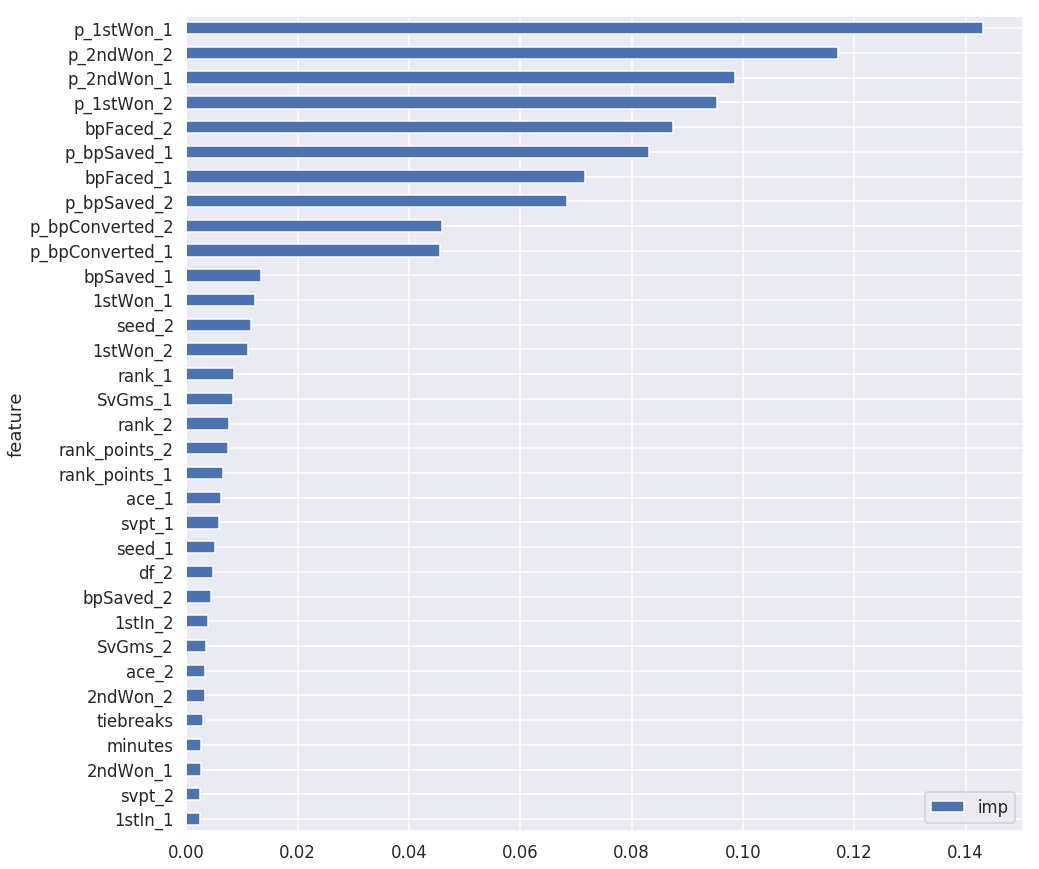

In [8]:
imp = clf.feature_importances_

pd.DataFrame({'feature': X.columns[imp > 0.001], 'imp': imp[imp > 0.001]}).set_index('feature').sort_values('imp')\
.plot(kind='barh', figsize=(15, 15))
plt.show()

## Decision tree


In [9]:
class DecisionTreeNode(object):
    def __init__(self, *pargs, **kwargs):
        self.left = None
        self.right = None

        if 'answer' in kwargs:
            self.is_leaf = True
            self.answer = kwargs['answer']
        else:
            self.is_leaf = False
            self.split_column = kwargs['split_column']
            self.split_value = kwargs['split_value']
            self.is_column_categorical = kwargs['is_column_categorical']
            if self.is_column_categorical:
                self.condition = lambda x: x.iloc[self.split_column] == self.split_value
            else:
                self.condition = lambda x: x.iloc[self.split_column] <= self.split_value

    def __str__(self):
        if self.is_leaf:
            return "Answer: {}".format(self.answer)
        else:
            return "Condition: feature {} {} {}".format(
                self.split_column, ('==' if self.is_column_categorical else "<="), self.split_value)

    def _str_features(self, features):
        if self.is_leaf:
            return "Answer: {}".format(self.answer)
        else:
            return "Condition: {} {} {}".format(
                features[self.split_column], ('==' if self.is_column_categorical else "<="), self.split_value)


class DecisionTree(object):

    # минимальное кол-во образцов, после которого не нужно делить, максимальная глубина, после которой не нужно делить
    def __init__(self, min_samples=2, max_depth=5, n_features=None, **kwargs):
        self.root = None
        self.min_samples = min_samples
        self.max_depth = max_depth
        self.n_features = n_features

    def fit(self, train_df):  # датафрейм, у которого ответы в последней колонке
        self._determine_type_of_features(train_df)
        self.features = train_df.columns
        self.root = self._build_decision_tree(train_df)

    def predict(self, test_df):  # датафрейм, у которого м.б. колонка с ответами (тогла мы делаем вид, что их нет :D)
        if self.root is None:
            raise Exception('Дерево ещё не построено. Сначала запустите fit()')

        res = dict()
        for index, example in test_df.iterrows():
            res[index] = self._classify_example(example)
        return pd.Series(res)

    #         return test_df.apply(self._classify_example, axis=1)

    def _build_decision_tree(self, data, level=0):
        # функция, возвращающая самый часто встречающийся в датасете класс (посл.колонка)
        def classify_data(data):
            return data.iloc[:, -1].mode().values[0]

            # случай остановки рекурсии:

        # 1) все строки имеют один класс; 2) достигнуто мин. число образцов в листе; 3) или макс.глубина
        if (data.iloc[:, -1].nunique() == 1) or (len(data) < self.min_samples) or (level == self.max_depth):
            return DecisionTreeNode(answer=classify_data(data))
        else:  # рекурсивная часть
            split_column, split_value = self._determine_best_split(data)  # находим наилучшее разбиение
            data_below, data_above = self._split_data(data, split_column, split_value)

            # проверяем, что это разделение не оставило с какой-то стороны 0 образцов
            if len(data_below) == 0 or len(data_above) == 0:
                return DecisionTreeNode(answer=classify_data(data))

            node = DecisionTreeNode(split_column=split_column, split_value=split_value,
                                    is_column_categorical=self.is_categorical[split_column])
            node.left = self._build_decision_tree(data_below, level + 1)
            node.right = self._build_decision_tree(data_above, level + 1)

            # проверяем случай совпадающих ответов (может быть, если датасет линейно неразделим)
            if node.left.is_leaf and node.right.is_leaf and node.left.answer == node.right.answer:
                node = DecisionTreeNode(answer=node.left.answer)

            return node

    # функция, определяющая тип признака на основе его типа данных (строка / не строка) и разнообразия значений
    def _determine_type_of_features(self, data):
        self.is_categorical = [False] * (data.shape[1] - 1)
        n_unique_values_treshold = 15
        for i in range(data.shape[1] - 1):  # кроме последней
            unique_values = data.iloc[:, i].unique()
            example_value = unique_values[0]
            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                self.is_categorical[i] = True

    # функция, выдающая словарь с потенциальными разделяющими значениями фич
    def _get_potential_splits(self, data):
        column_indices = list(range(data.shape[1] - 1))
        if self.n_features and self.n_features < (data.shape[1] - 1):
            column_indices = random.sample(column_indices, k=self.n_features)

        potential_splits = dict()
        for column_index in column_indices:  # excluding the last column which is the label
            values = data.iloc[:, column_index]
            if self.is_categorical[column_index]:
                unique_values = np.unique(values)
            else:
                if len(values) > 100:
                    values = np.random.choice(values, replace=False, size=100)
                unique_values = np.unique(values)
                if len(unique_values) > 10:  # если уникальных значений много, используем вместо них процентили
                    unique_values = np.percentile(unique_values, np.linspace(0, 100, 11))

            potential_splits[column_index] = unique_values

        return potential_splits

    # функция, разделяющая датасет на две части по некоторому значению признака
    def _split_data(self, data, split_column, split_value):
        if self.is_categorical[split_column]:
            data_below = data[data.iloc[:, split_column] == split_value]
            data_above = data[data.iloc[:, split_column] != split_value]
        else:
            data_below = data[data.iloc[:, split_column] <= split_value]
            data_above = data[data.iloc[:, split_column] > split_value]
        return data_below, data_above

    # функция, вычисляющая энтропию для данного датасета
    def _entropy(self, data):
        p = data.iloc[:, -1].value_counts(normalize=True, sort=False).values
        return -(p * np.log2(p)).sum()

    # функция, вычисляющая взвешенную по числу образцов энтропию для двух датасетов (после разбиения)
    def _calculate_entropy_for_split(self, data_below, data_above):
        n = len(data_below) + len(data_above)
        p_below, p_above = len(data_below) / n, len(data_above) / n
        return (p_below * self._entropy(data_below) + p_above * self._entropy(data_above))

    # функция, по данному словарю с разбиениями находящая наилучшее с точки зрения энтропии
    def _determine_best_split(self, data):
        potential_splits = self._get_potential_splits(data)
        min_entropy = 9999
        for column_index in potential_splits:
            for value in potential_splits[column_index]:
                data_below, data_above = self._split_data(data, split_column=column_index, split_value=value)
                current_entropy = self._calculate_entropy_for_split(data_below, data_above)
                if current_entropy <= min_entropy:
                    min_entropy, best_split_column, best_split_value = current_entropy, column_index, value

        return best_split_column, best_split_value

    def _classify_example(self, example, cur_node=None):  # классифицируем образец с помощью построенной модели
        if cur_node is None:
            cur_node = self.root

        # print(cur_node)
        if cur_node.is_leaf:  # если мы попали в лист дерева

            return cur_node.answer

        if cur_node.condition(example):  # иначе рекурсивно запускаем вычисление ответа на поддереве
            return self._classify_example(example, cur_node=cur_node.left)
        else:
            return self._classify_example(example, cur_node=cur_node.right)

    def __str__(self):
        if self.root is None:
            return "Empty tree!"

        return self._str_level(self.root)

    def _str_level(self, node, level=0, lr=''):
        res = '\t' * level + lr + node._str_features(self.features) + '\n'
        if node.left:
            res += self._str_level(node.left, level + 1, 'L: ')
        if node.right:
            res += self._str_level(node.right, level + 1, 'R: ')
        return res


def train_test_split(df, test_size):
    if isinstance(test_size, float):
        test_size = round(test_size * len(df))

    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)

    return train_df, test_df


def calculate_accuracy(labels_pred, labels_true):
    return (labels_pred == labels_true).mean()

## Decision tree testing

In [8]:
df = pd.read_csv('iris.csv')
df.head(6)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
5,5.4,3.9,1.7,0.4,Setosa


In [82]:
df = pd.read_table('titanic.tsv')
df = df.loc[:, list(set(df.columns) - set(['Survived', 'Ticket', 'Name','Cabin', 'PassengerId'])) + ['Survived']]
median_age = df.Age.median()
mode_embarked = df.Embarked.mode()[0]
df = df.fillna({"Age": median_age, "Embarked": mode_embarked})
df.head()

,SibSp,Sex,Fare,Parch,Pclass,Embarked,Age,Survived
0,1,male,7.2500,0,3,S,22.0,0
1,1,female,71.2833,0,1,C,38.0,1
2,0,female,7.9250,0,3,S,26.0,1
3,1,female,53.1000,0,1,S,35.0,1
4,0,male,8.0500,0,3,S,35.0,0


In [12]:
train_df, test_df = train_test_split(df, test_size=0.3)
tree = DecisionTree(max_depth=4)
%time tree.fit(train_df)

CPU times: user 15.2 s, sys: 83.4 ms, total: 15.3 s
Wall time: 15.3 s


In [13]:
print(tree)

predictions = tree.predict(test_df)
calculate_accuracy(predictions, test_df.iloc[:,-1])

Condition: rank_2 <= 217.20000000000005
	L: Condition: hand_2_R == 1
		L: Answer: 0
		R: Condition: hand_2_L == 1
			L: Answer: 0
			R: Answer: 1
	R: Condition: hand_2_R == 1
		L: Answer: 0
		R: Condition: hand_2_L == 1
			L: Answer: 0
			R: Answer: 1



0.999800704178569

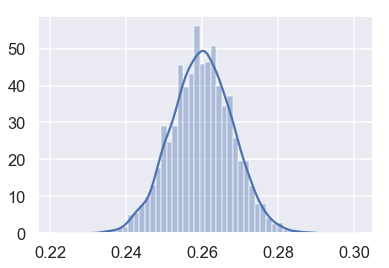

In [69]:
means = []
for i in range(10000):
    a = np.array([0]*int(0.74*3000) + [1]*int(0.26*3000))
    b = np.random.choice(a, 3000)
    means.append(b.mean())
sns.distplot(means)

## Random forest

In [1]:
class RandomForest(object): 
    # число деревьев в лесу,
    # минимальное кол-во образцов, после которого не нужно делить, максимальная глубина, после которой не нужно делить
    def __init__(self, n_trees, dt_min_samples=2, dt_max_depth=5, dt_n_features=None, **kwargs):
        self.trees = []
        self.n_trees = n_trees
        self.min_samples = dt_min_samples
        self.max_depth = dt_max_depth
        self.n_features = dt_n_features

    def fit(self, train_df):  # датафрейм, у которого ответы в последней колонке
        self.trees = []
        for i in tqdm_notebook(range(self.n_trees)):
            df_bootstrapped = self._bootstrapping(train_df)
            tree = DecisionTree(max_depth=self.max_depth, n_features=self.n_features, min_samples=self.min_samples)
            tree.fit(df_bootstrapped)
            self.trees.append(tree)
            

    def predict(self, test_df):  # датафрейм, у которого м.б. колонка с ответами (тогла мы делаем вид, что их нет)
        df_predictions = self._trees_predictions(test_df)
        return df_predictions.mode(axis=1)[0]
    
    def _bootstrapping(self, df):
        bootstrap_indices = np.random.randint(low=0, high=df.shape[0], size=df.shape[0])
        df_bootstrapped = df.iloc[bootstrap_indices]

        return df_bootstrapped
    
    def _trees_predictions(self, test_df):
        if self.trees == []:
            raise Exception('Лес ещё не построен. Сначала запустите fit()')
        
        df_predictions = {}
        for i in range(self.n_trees):
            df_predictions["tree_{}".format(i)] = self.trees[i].predict(test_df)
        df_predictions = pd.DataFrame(df_predictions)
        return df_predictions
    
    def random_forest_optimal_n_trees(self, test_df):
        if self.trees == []:
            raise Exception('Лес ещё не построен. Сначала запустите fit()')
        
        df_predictions = self._trees_predictions(test_df)
        
        res = dict()
        for n_trees in tqdm_notebook(range(1, self.n_trees+1, 2)):
            trees_ind = np.random.choice(range(self.n_trees), size=n_trees, replace=False)
            random_forest_predictions = df_predictions.iloc[:,trees_ind].mode(axis=1)[0]
            res[n_trees] = calculate_accuracy(random_forest_predictions, test_df.iloc[:, -1])
        return res
    
    def __str__(self):
        res = ''
        for i in range(self.n_trees):
            res += 'TREE {}'.format(i) + '\n'
            res += str(self.trees[i])
            res += '\n'
        return res

In [88]:
# подбор оптимального значения гиперпараметра -- в данном случае число деревьев
forest = RandomForest(n_trees=50, dt_n_features=int(np.sqrt(train_df.shape[1])), dt_max_depth=5)
%time forest.fit(train_df)


Wall time: 15.1 s


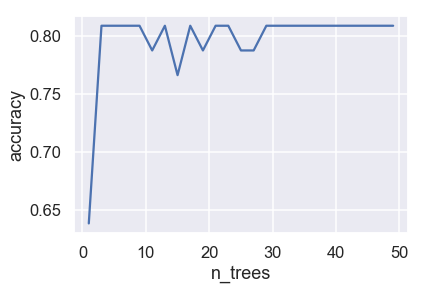

In [89]:
res = forest.random_forest_optimal_n_trees(test_df)
pd.Series(res).plot()
plt.xlabel('n_trees')
plt.ylabel('accuracy')
plt.show()

In [10]:
df = pd.read_csv('./tennis_shuffled_imputed.csv', index_col=0)
w = df['W']
df = df.drop(columns=['W'])
df['W'] = w
print(df.shape)
df.head()

(50178, 77)


,draw_size,minutes,tiebreaks,best_of,seed_1,ht_1,age_1,rank_1,rank_points_1,ace_1,...,hand_1_U,entry_2_LL,entry_2_PR,entry_2_Q,entry_2_S,entry_2_WC,hand_2_L,hand_2_R,hand_2_U,W
45460,4,103.89723,1,3,999999.0,185.325882,19.427789,999999.0,0.0,5.875458,...,1,0,0,0,0,0,0,0,1,0
12468,128,140.00000,3,5,999999.0,178.000000,26.913073,117.0,402.0,8.000000,...,0,0,0,0,0,0,0,1,0,0
34638,128,191.00000,3,5,999999.0,185.000000,28.700890,68.0,715.0,5.000000,...,0,0,0,0,0,0,0,1,0,0
45037,128,125.00000,1,5,999999.0,188.000000,29.475702,37.0,968.0,5.000000,...,0,0,0,0,0,0,0,1,0,1
46917,48,72.00000,1,3,7.0,175.000000,24.377823,8.0,2090.0,1.000000,...,0,0,0,0,0,0,0,1,0,1


In [11]:
random.seed(0)
train_df, test_df = train_test_split(df, test_size=0.3)

In [12]:
tree = DecisionTree(max_depth=5)
%time tree.fit(train_df)

KeyboardInterrupt: 

In [93]:
print(tree)

Condition: p_1stWon_2 <= 0.6736622073578595
	L: Condition: p_1stWon_1 <= 0.6568238213399504
		L: Condition: p_2ndWon_1 <= 0.5114979386165827
			L: Condition: p_2ndWon_2 <= 0.47235294117647053
				L: Condition: p_1stWon_2 <= 0.5864596273291927
					L: Answer: 1
					R: Answer: 0
				R: Answer: 0
			R: Condition: p_2ndWon_2 <= 0.5204508856682769
				L: Answer: 1
				R: Condition: p_1stWon_2 <= 0.5976119402985074
					L: Answer: 1
					R: Answer: 0
		R: Condition: bpFaced_1 <= 5.3999999999999995
			L: Answer: 1
			R: Condition: p_2ndWon_2 <= 0.518945868945869
				L: Answer: 1
				R: Condition: p_2ndWon_1 <= 0.4615384615384616
					L: Answer: 0
					R: Answer: 1
	R: Condition: p_1stWon_1 <= 0.6756756756756757
		L: Condition: bpFaced_2 <= 5.2
			L: Answer: 0
			R: Condition: p_bpConverted_1 <= 0.34761904761904755
				L: Answer: 0
				R: Condition: p_2ndWon_1 <= 0.4938271604938271
					L: Answer: 0
					R: Answer: 1
		R: Condition: p_2ndWon_2 <= 0.5464285714285715
			L: Condition: p_2ndWon_1

In [94]:
predictions = tree.predict(test_df)
print(calculate_accuracy(predictions, test_df.iloc[:,-1]))

0.8205008968311964


In [13]:
# подбор оптимального значения гипэрпарамэтра -- в данном случае число деревьев
forest = RandomForest(n_trees=50, dt_n_features=int(np.sqrt(train_df.shape[1])), dt_max_depth=4)
%time forest.fit(train_df)


Wall time: 6min 4s


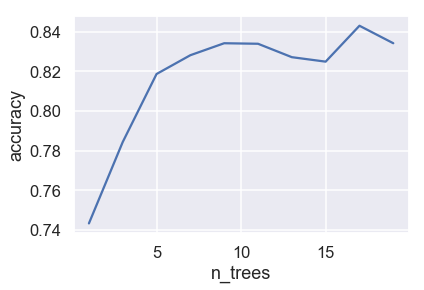

In [97]:
res = forest.random_forest_optimal_n_trees(test_df)
pd.Series(res).plot()
plt.xlabel('n_trees')
plt.ylabel('accuracy')
plt.show()